$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

In [1]:
from concurrent.futures import ProcessPoolExecutor
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from z3 import *
import time

# Problema 2: Pidgeon Hole Principle

Se dispusermos de $N$ pombos e $N-1$ poleiros, é impossível colocar um pombo em cada poleiro.

## Condições Lógica Inteira

Para resolver este problema, foi criado um grupo de variáveis binárias que tomam valores inteiros:
 - $p_{n, m}$: variável que representa a presença do pombo $n$ no poleiro $m$.
 
Onde $n$ e $m$ são inteiros tais que $n \in [0, N-1]$ e $m \in [0, N-2]$.

As restrições impostas nas variáveis são as seguintes:

1. Cada pombo deve ocupar sempre um e um só poleiro:
$$ \sum_{m=0}^{N-2} p_{n,m} = 1, \forall_n $$

2. Cada poleiro pode apenas ter no máximo um pombo:
$$ \sum_{n=0}^{N-1} p_{n, m} \le 1, \forall_m $$

In [2]:
def php_int(N):
    start = time.time()
    
    # Criar o solver e as variáveis
    solver = Solver()
    p = [[Int(f'{n},{m}') for m in range(N-1)] for n in range(N)]
    
    # Condição 1: Cada pombo deve ocupar sempre um poleiro
    for n in p:
        solver.add(sum([m for m in n]) == 1)
    
    # Condição 2: Cada poleiro deve conter no máximo um pombo
    p = list(np.array(p).transpose())
    for m in p:
        solver.add(sum([n for n in m]) <= 1)
        
    # Verificar que é insatisfazível
    assert solver.check() == unsat
    
    return time.time() - start

## Condições Lógica Proposicional

Para resolver este problema, foi criado um grupo de variáveis binárias booleanas:
 - $p_{n, m}$: variável que representa a presença do pombo $n$ no poleiro $m$.
 
Onde $n$ e $m$ são inteiros tais que $n \in [0, N-1]$ e $m \in [0, N-2]$

1. Cada pombo deve ocupar sempre um e um só poleiro, ou seja, cada pombo deve ocupar pelo menos um poleiro (1) e cada pombo deve ocupar no máximo um poleiro (2):
\begin{equation}
\bigvee_{m=0}^{N-2} p_{n,m}, \forall_n
\tag{1}
\end{equation}

\begin{equation}
p_{n, m} \rightarrow \bigwedge_{i=0, i \neq m}^{N-2} \left( \neg p_{n, i} \right) \forall_{n,m}
\tag{2}
\end{equation}

2. Cada poleiro tem no máximo um pombo:
$$ p_{n, m} \rightarrow \bigwedge_{i=0, i \neq n}^{N-1} \left( \neg p_{i, m} \right), \forall_{n, m} $$

In [3]:
def php_bool(N):
    start = time.time()
    
    # Criar o solver e as variáveis
    solver = Solver()
    p = [[Bool(f'{n},{m}') for m in range(N-1)] for n in range(N)]
    
    # Condição 1: Cada pombo deve ocupar sempre um poleiro
    for i in range(len(p)):
        solver.add(Or([p[i][j] for j in range(len(p[i]))]))
        for j in range(len(p[i])):
            conds = []
            for k in range(len(p[i])):
                if j != k:
                    conds.append(Not(p[i][k]))
            solver.add(Implies(p[i][j], And(conds)))

    # Condição 2: Cada poleiro deve conter no máximo um pombo
    for i in range(len(p)):
        for j in range(len(p[i])):
            conds = []
            for k in range(len(p)):
                if i != k:
                    conds.append(Not(p[k][j]))
            solver.add(Implies(p[i][j], And(conds)))

    # Verificar que é insatisfazível
    assert solver.check() == unsat

    return time.time() - start

In [69]:
# Calcular os tempos de execução de PHP Int
num_max_int, times_int = 100, []
for i in tqdm(range(1, num_max+1), total=num_max, desc="PHP Int"):
    times_int.append(php_int(i))

PHP Int: 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


In [4]:
# Calcular os tempos de execução de PHP Bool
num_max_bool, times_bool = 13, []
with ProcessPoolExecutor() as executor:
    iters = [i for i in range(1, num_max+1)]
    times_bool = list(tqdm(executor.map(php_bool, iters), total=num_max, desc="PHP Bool"))

PHP Bool: 100%|██████████| 13/13 [22:37<00:00, 104.46s/it]


Fazendo plot e escrevendo os respetivos polinómios de ajuste (obtidos através do numpy) dos tempos de execução, obtemos a seguinte figura: polinómios

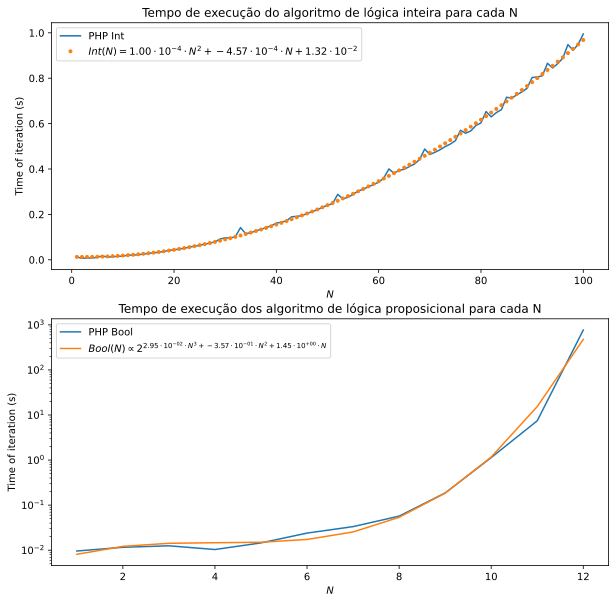

In [148]:
# Obtenção dos polinómios de ajuste
x_axis = [i for i in range(1, num_max_int+1)]
poly2_c = np.polyfit(x_axis,times_int,2)
poly2 = [sum([poly2_c[i] * x ** (2-i) for i in range(len(poly2_c))]) for x in x_axis]
poly2_c = [f'{p:.2e}'.split('e')[0] + " \\cdot 10^{" + f"{p:.2e}".split('e')[1].replace('0','') + "}" for p in poly2_c]

# Função de ajuste do PHP_Bool
x_axis_bool = [i for i in range(1, num_max_bool+1)]
log_bool = np.log2(times_bool)
coefs = np.polyfit(x_axis_bool, log_bool, 3)
poly = [2 ** (coefs[0] * x**3 + coefs[1] * x**2 + coefs[2] * x + coefs[3]) for x in x_axis_bool]
coefs = [f'{p:.2e}'.split('e')[0] + " \\cdot 10^{" + f"{p:.2e}".split('e')[1].replace('e', '0') + "}" for p in coefs]

# Representação dos tempos de execução e dos polinómios de ajuste
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10,10))

# Plot do PHP Int
ax.set_title("Tempo de execução do algoritmo de lógica inteira para cada N")
ax.plot(x_axis, times_int, label="PHP Int")
ax.plot(x_axis, poly2, ".",label=f"$Int(N) = {poly2_c[0]} \\cdot N^2 + {poly2_c[1]} \\cdot N + {poly2_c[2]}$")
ax.set_ylabel("Time of iteration (s)")
ax.set_xlabel("$N$")
ax.legend()

# Plot do PHP Bool
ax2.set_title("Tempo de execução dos algoritmo de lógica proposicional para cada N")
ax2.plot(x_axis_bool, times_bool, label="PHP Bool")
ax2.plot(x_axis_bool, poly, label="$Bool(N) \\propto 2^{" + f"{coefs[0]} \\cdot N^3 + {coefs[1]} \\cdot N^2 + {coefs[2]} \\cdot N" + "}$")
ax2.set_ylabel("Time of iteration (s)")
ax2.set_xlabel("$N$")
ax2.set_yscale("log")
ax2.legend()

plt.show()

Por análise da figura anterior e dos polinómios pode-se verificar que:

 - Para o algoritmo com lógica inteira, verifica-se um tempo de execução $T(N) \in \mathcal{O}(N^{2})$ para os inputs testados
 - Para o algoritmo com lógica proposicional, verifica-se que o seu crescimento aparenta ser exponencial  - cujo expoente é uma função polinomial $g(N)$ - sendo então o seu tempo de execução $T(N) \in \mathcal{O}\left(2^{g(N)} \right)$ para os inputs testados
 
Como tal, interpolando as relações dos tempos de execução acima descritas para inputs $N$ que nem precisam de ser muito elevados, o algoritmo de lógica proposicional torna-se cada vez mais computacionalmente dispendioso relativamente ao algoritmo de lógica inteira, chegando mesmo a ser incomputável para valores de $N$ suficientemente grandes.